# Input

In [19]:
FILE = "stats.csv"
TRENDS_VARIABLES = [
    ("num_mb", 5),
    ("num_tp", 4),
    ("num_dp", 5),
    ("num_layers", 4),
    ("num_pp", 4), 
    ("gbs", 4),
    ("num_heads", 5),
    ("hidden_size", 4),
    ("seqlen", 5),
]


# Definition
Plot Functions

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple

@dataclass
class PlotConfig:
    figsize = (8,6)
    font_big = 30
    font_small = 25
    font_legend = 15

def draw_lines(data: Dict[str,List], 
               xlabel: str = "", 
               ylabel: str = "",
               highlight_idxs: List = None,
               ylim: Tuple[int] = None,
               
               export_fname: str = "",
               show: bool = False,
               cfg: PlotConfig = None):
    
    highlight_idxs = highlight_idxs or []
    cfg  = cfg or PlotConfig()
    
    # data
    df = pd.DataFrame(data)
    plt.figure(figsize=cfg.figsize)
    plt.plot(df['X'], df['Y'], marker='o', color='darkcyan', linestyle='-', linewidth=2, markersize=8)
    
    # label
    if xlabel:
        plt.xlabel(xlabel, fontsize=cfg.font_big)
    if ylabel:
        plt.ylabel(ylabel, fontsize=cfg.font_big)
        
    # ticks
    plt.xticks(df['X'], fontsize=cfg.font_small)
    plt.yticks(fontsize=cfg.font_small)
    
    # range
    if ylim:
        plt.ylim(*ylim)
    
    # highlights
    for i in highlight_idxs:
        plt.scatter(df['X'][i], df['Y'][i], color='orange', zorder=5, marker='s', s=100)

    # export
    plt.tight_layout()
    if export_fname:
        plt.savefig(f"figs/{export_fname}.pdf", format="pdf", transparent=True, bbox_inches='tight', pad_inches=0)
    
    # display
    if show:
        print(export_fname)
        plt.show()



In [21]:

def draw_hybrid(data: Dict[str, List], 
         xlabel: str = "", 
         ylabel: str = "",
         highlight_idxs: List = None,
         ylim: Tuple[int] = None,
         export_fname: str = "",
         show: bool = False,
         cfg: PlotConfig = None,
         legend: bool = False,
         uniform_spacing: bool = False,
         component_labels: List[str] = None):

    highlight_idxs = highlight_idxs or []
    cfg = cfg or PlotConfig()

    x = data["X"]
    positions = list(range(len(x))) if uniform_spacing else x
    components = data["Y"]  # shape: [component][x_index]
    num_components = len(components)

    if component_labels is None:
        component_labels = [f'Component {i+1}' for i in range(num_components)]

    default_colors = ["264653","2a9d8f","e9c46a","f4a261","e76f51"]
    default_colors = [f"#{c}" for c in default_colors]
    assert len(default_colors) >= num_components, f"not enough colors"
    
    fig, ax = plt.subplots(figsize=cfg.figsize)
    
    # xlim
    if uniform_spacing:
        ax.set_xlim(-0.5, len(x) - 0.5)
    else:
        XLIM_ALPHA = 1 / (len(x)+1)
        xrange = max(x)-min(x) + 1
        xlim_margin = xrange * XLIM_ALPHA
        # ax.set_xlim(min(x) - xlim_margin, max(x) + xlim_margin)
        ax.set_xlim(None, max(x) + xlim_margin)

    # Bar Width
    ABS_BAR_WIDTH = 0.3
    # Get figure size and axis position
    fig_width_inch = fig.get_size_inches()[0]
    xlim = ax.get_xlim()
    xrange = xlim[1] - xlim[0]
    # Compute bar width in data units
    bar_width = (ABS_BAR_WIDTH / fig_width_inch) * xrange
    
    # Bar plot (stacked components)
    bottom = [0] * len(x)
    for comp_vals, color, label in zip(components, default_colors, component_labels):
        ax.bar(positions, comp_vals, bottom=bottom, width=bar_width, label=label, color=color, zorder=2)
        bottom = [b + v for b, v in zip(bottom, comp_vals)]

    # Line plot (total)
    total_vals = [sum(comp.iloc[i] for comp in components) for i in range(len(x))]
    ax.plot(positions, total_vals, marker='o', color='black', linewidth=2.5, label='Total', zorder=3)

    # Highlight selected indices (optional)
    for i in highlight_idxs:
        ax.scatter(positions[i], total_vals[i], color='orange', s=100, zorder=4, edgecolor='black', marker='s')

    # Labels and ticks
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=cfg.font_small)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=cfg.font_small)

    ax.set_xticks(positions)
    ax.set_xticklabels(x, fontsize=cfg.font_small)
    ax.tick_params(axis='y', labelsize=cfg.font_small)

    # ylim
    YLIM_ALPHA = 1.3
    if ylim:
        plt.ylim(*ylim)
    else:
        ax.set_ylim(None, YLIM_ALPHA*max(total_vals))

    # legend
    if legend:
        ax.legend(fontsize=cfg.font_legend)
        ax.grid(axis='y', linestyle='--', linewidth=0.5, zorder=1)
        
    plt.tight_layout()
    
    if export_fname:
        plt.savefig(f"figs/{export_fname}.pdf", format="pdf", transparent=True, bbox_inches='tight', pad_inches=0)
    if show:
        print(export_fname)
        plt.show()

Data Preparation

In [22]:
# sanity check
df_full = pd.read_csv(FILE)
df_num_rows = len(df_full)
expected_num_rows = sum([cnt for _,cnt in TRENDS_VARIABLES])
assert df_num_rows == expected_num_rows, f"dataframe has inconsistent number of rows: {df_num_rows} != {expected_num_rows}."

def get_var_slc_range(var: str):
    start = 0
    end = 0
    assigned = False
    for name, cnt in TRENDS_VARIABLES:
        if name == var:
            assigned = True
            end = start + cnt
            break
        else:
            start += cnt
    assert assigned, f"{var} not in valid variable names: {[name for name,_ in TRENDS_VARIABLES]}"
    return (start, end)

def get_var_df(var: str):
    start, end = get_var_slc_range(var)
    return df_full[start:end]
    

Plot Variable Trends

In [23]:
def plot_trends(var: str, **kwargs):
    export_fname = f"trends_{var}"
    df = get_var_df(var)
    data = {
        "X": df[var],
        "Y": [
            df["t_graph"],
            df["t_lineage"],
            df["t_schedule"],
            df["t_vrf"],
        ]
    }
    draw_hybrid(data,
                component_labels = ["create SSA DAGs", "infer lineages", "determine stages", "verification"],
                ylabel="time(s)",
                export_fname=export_fname, show=True, legend=False, **kwargs)
    

# Plot

trends_num_mb


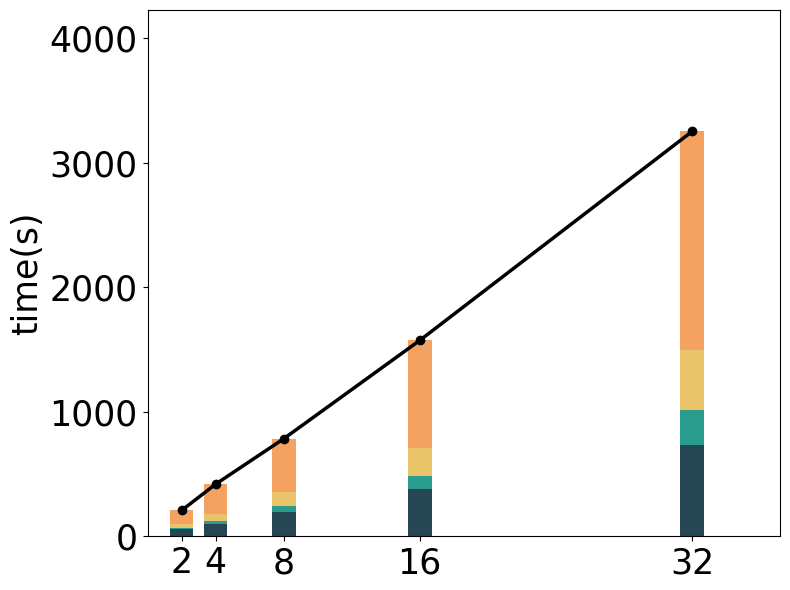

trends_num_tp


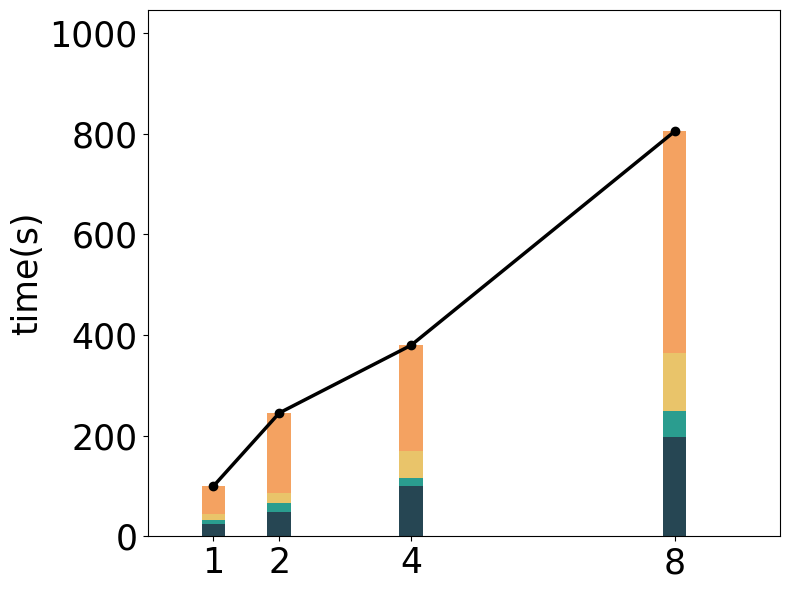

trends_num_dp


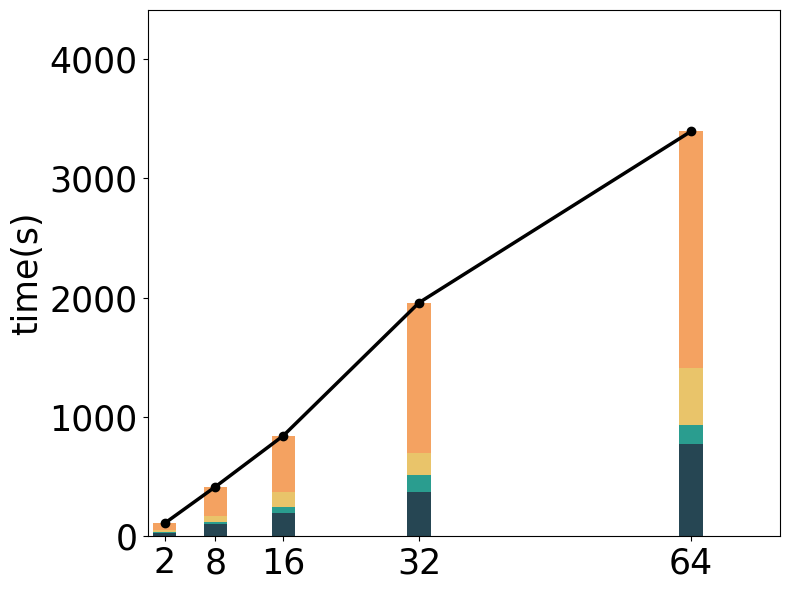

trends_num_layers


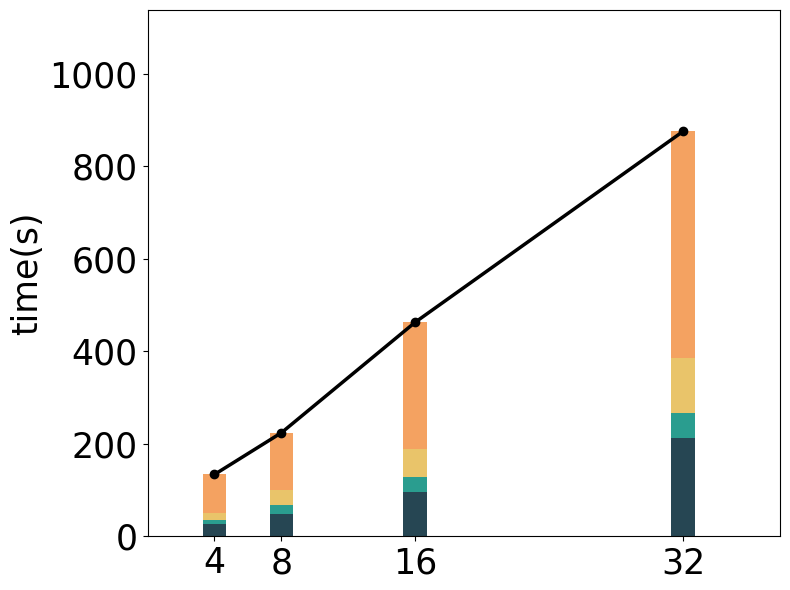

trends_num_pp


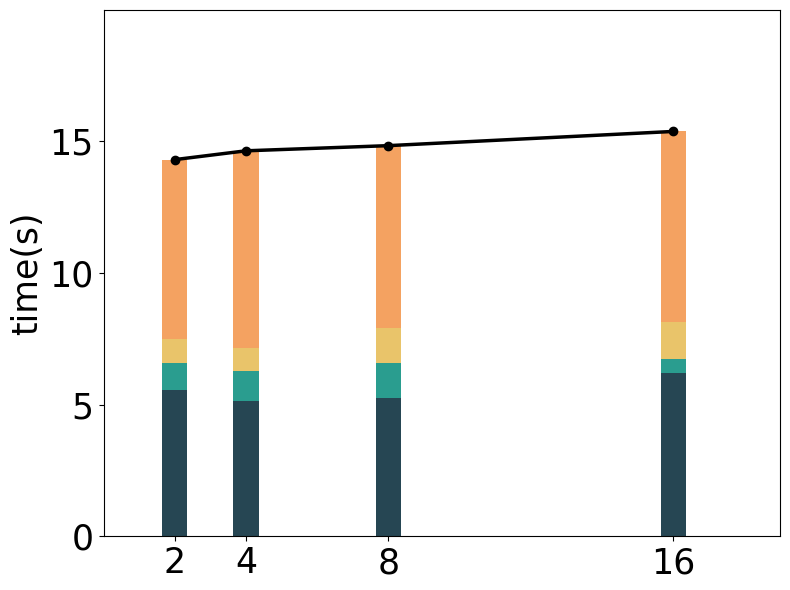

trends_gbs


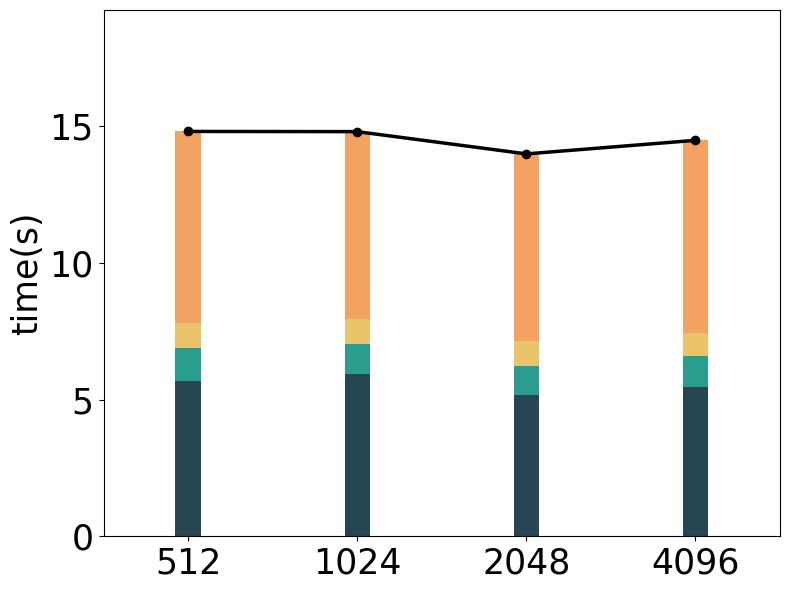

trends_num_heads


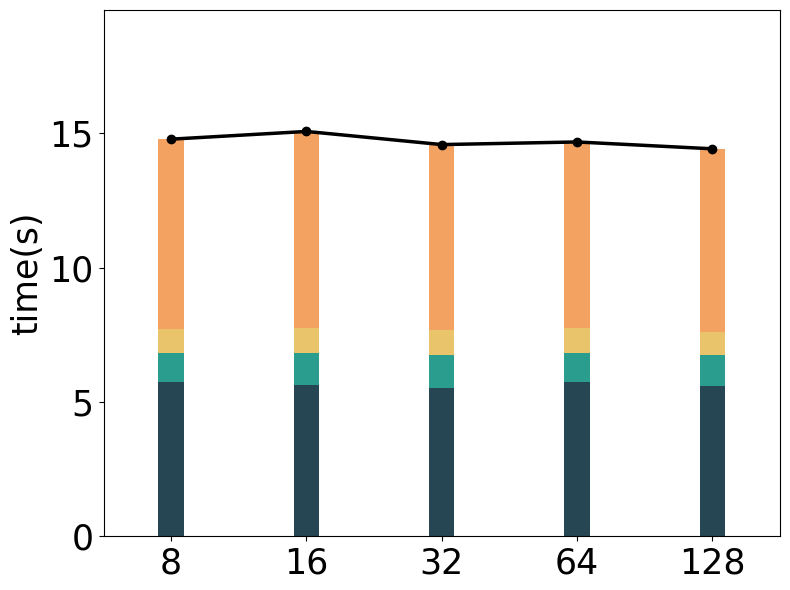

trends_hidden_size


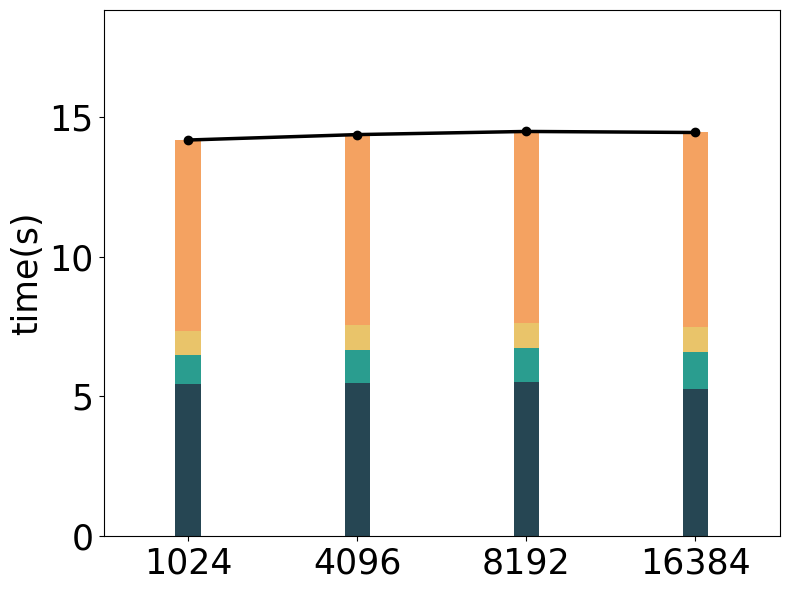

trends_seqlen


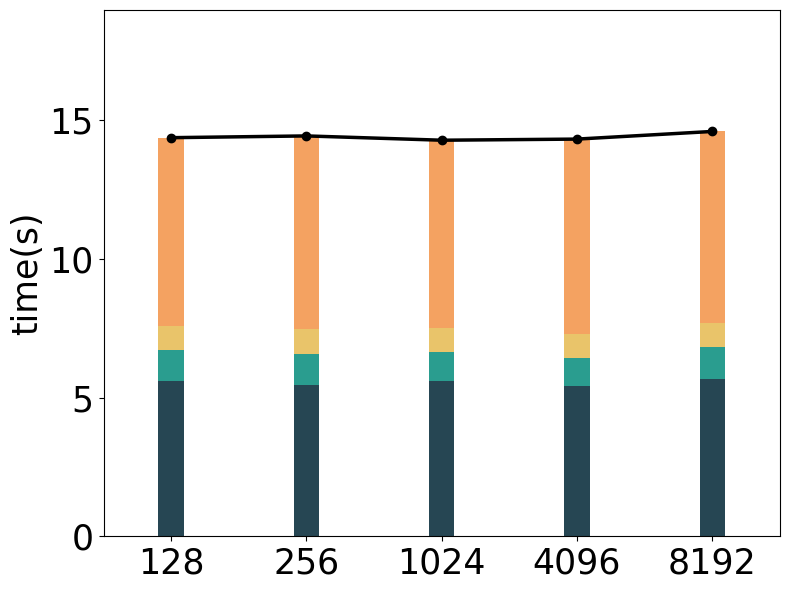

In [24]:
# ("nm", 3),
# ("tp", 2),
# ("dp", 2),
# ("layers", 2),
# ("pp", 1),
# ("gbs", 1),
# ("heads", 2),
# ("hidden", 2),
# ("seqlen", 1),

plot_trends("num_mb", highlight_idxs=[])
plot_trends("num_tp", highlight_idxs=[])
plot_trends("num_dp", highlight_idxs=[])
plot_trends("num_layers", highlight_idxs=[])
plot_trends("num_pp", highlight_idxs=[])
plot_trends("gbs", highlight_idxs=[], uniform_spacing=True)
plot_trends("num_heads", highlight_idxs=[], uniform_spacing=True)
plot_trends("hidden_size", highlight_idxs=[], uniform_spacing=True)
plot_trends("seqlen", highlight_idxs=[], uniform_spacing=True)